In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import sklearn as sk
import pandas as pd 
%matplotlib inline
layers = tf.keras.layers

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


this is for leaf classification

In [ ]:

# dataset = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/img_c', batch_size = BATCH_SIZE, image_size = (IMAGE_SIZE ,IMAGE_SIZE),seed = 123,shuffle = True)

this is for breast cancer 

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/breast_cancer_img_c', batch_size = BATCH_SIZE, image_size = (IMAGE_SIZE ,IMAGE_SIZE),seed = 123,shuffle = True)

Found 1588 files belonging to 3 classes.


this is for ct scans of breast

In [ ]:
# train = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/img_breast_c/train', batch_size = BATCH_SIZE, image_size = (IMAGE_SIZE ,IMAGE_SIZE),seed = 123,shuffle = True)
# test = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/img_breast_c/test', batch_size = BATCH_SIZE, image_size = (IMAGE_SIZE ,IMAGE_SIZE),seed = 123,shuffle = True)
# valid = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/img_breast_c/valid', batch_size = BATCH_SIZE, image_size = (IMAGE_SIZE ,IMAGE_SIZE),seed = 123,shuffle = True)


In [ ]:
len(dataset)

50

In [ ]:
CLASS_NAMES = dataset.class_names
print(CLASS_NAMES) 

['benign', 'malignant', 'normal']


(32, 256, 256, 3)
normal
[2 0 0 0 1 2 0 1 1 2 2 0 0 1 1 1 1 0 0 0 1 0 2 0 0 0 1 2 0 1 2 1]


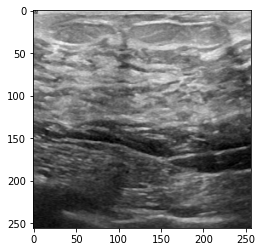

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape) 
  print(CLASS_NAMES[label_batch[0]]) 
  print(label_batch.numpy())
  plt.imshow(image_batch[0].numpy().astype('uint8')) 

In [ ]:
print(len(image_batch))

32


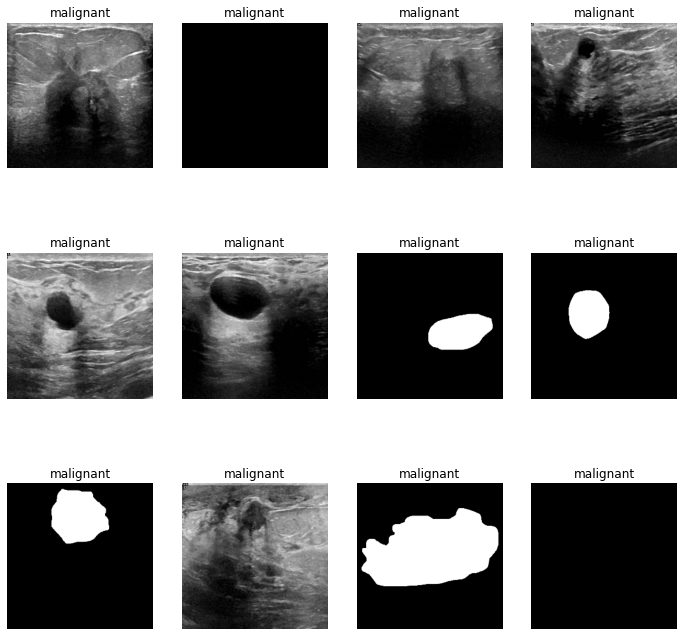

In [ ]:
plt.figure(figsize = (12,12))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(CLASS_NAMES[label_batch[0]]) 
    plt.axis('off')


In [ ]:
from re import L
def dataset_split(df,train_size= 0.8 , test_size = 0.1 ,validation_size = 0.1, shuffle=True, shuffle_size=10000) :

  assert (train_size + test_size + validation_size) == 1
  l = len(dataset)

  if shuffle:
    df = df.shuffle(shuffle_size, seed=12)

  TRAIN_SIZE = int(train_size*l)
  TEST_SIZE = int(test_size*l)
  VALIDATION_SIZE = int(validation_size*l)
  print('###')
  print(TRAIN_SIZE)
  df_train = df.take(TRAIN_SIZE)
  df_validation = df.skip(TRAIN_SIZE).take(VALIDATION_SIZE)
  df_test = df.skip(TRAIN_SIZE).skip(VALIDATION_SIZE).take(TEST_SIZE)

  return df_train , df_validation, df_test

In [ ]:
df_train , df_validation, df_test = dataset_split(dataset) 

###
40


In [ ]:
print(df_test)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(len(df_train))

40


In [ ]:
print(len(df_validation) , len(df_test))

5 5


In [ ]:
print(len(dataset))

50


In [ ]:
df_train = df_train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
df_validation = df_validation.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
df_test = df_test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
reshape = tf.keras.Sequential([
                     tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,
                     tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)

])

In [ ]:
data_augumentation = tf.keras.Sequential([
                     tf.keras.layers.experimental.preprocessing.RandomFlip(mode= 'horizontal_and_vertical') ,
                     tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),

])

In [ ]:
from tensorflow.keras import models

In [ ]:
input_shape = (BATCH_SIZE , IMAGE_SIZE, IMAGE_SIZE , 3)
model1 = tf.keras.models.Sequential([ 
                              reshape,
                              # data_augumentation,
                              tf.keras.layers.Conv2D(64, kernel_size = (3,3) , activation = 'relu' , input_shape = input_shape) ,
                              layers.MaxPooling2D((2,2)) ,

                              tf.keras.layers.Conv2D(64, kernel_size = (3,3) , activation = 'relu' , input_shape = input_shape) ,
                              layers.MaxPooling2D((2,2)) ,

                              tf.keras.layers.Conv2D(64, kernel_size = (3,3) , activation = 'relu' , input_shape = input_shape) ,
                              layers.MaxPooling2D((2,2)) ,

                              layers.Flatten(),
                              layers.Dense(63,activation = 'relu'),
                              layers.Dense(len(CLASS_NAMES),activation = 'softmax')
])

model1.build(input_shape = input_shape) 

In [ ]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
len(df_train)

40

In [ ]:
history = model1.fit(
    df_train,
    batch_size=BATCH_SIZE,
    validation_data=df_validation,
    verbose=1,
    epochs= EPOCHS
)  

Epoch 1/30
40/40 [==============================] - 214s 436ms/step - loss: 0.8961 - accuracy: 0.5695 - val_loss: 0.7713 - val_accuracy: 0.6014
Epoch 2/30
40/40 [==============================] - 7s 175ms/step - loss: 0.7401 - accuracy: 0.6711 - val_loss: 0.6797 - val_accuracy: 0.6892
Epoch 3/30
40/40 [==============================] - 7s 174ms/step - loss: 0.5755 - accuracy: 0.7359 - val_loss: 0.5503 - val_accuracy: 0.7432
Epoch 4/30
40/40 [==============================] - 7s 175ms/step - loss: 0.4537 - accuracy: 0.7805 - val_loss: 0.4435 - val_accuracy: 0.8041
Epoch 5/30
40/40 [==============================] - 7s 175ms/step - loss: 0.3795 - accuracy: 0.8172 - val_loss: 0.4533 - val_accuracy: 0.7838
Epoch 6/30
40/40 [==============================] - 7s 177ms/step - loss: 0.3060 - accuracy: 0.8820 - val_loss: 0.2457 - val_accuracy: 0.9189
Epoch 7/30
40/40 [==============================] - 7s 175ms/step - loss: 0.1918 - accuracy: 0.9359 - val_loss: 0.1979 - val_accuracy: 0.9392
Epoc

In [ ]:
scores = model1.evaluate(df_test)

5/5 [==============================] - 8s 73ms/step - loss: 0.6891 - accuracy: 0.9500


In [ ]:
history

In [ ]:
history.params

{'epochs': 30, 'steps': 40, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.569531261920929,
 0.671093761920929,
 0.7359374761581421,
 0.780468761920929,
 0.817187488079071,
 0.882031261920929,
 0.9359375238418579,
 0.9624999761581421,
 0.9765625,
 0.97265625,
 0.9789062738418579,
 0.9820312261581421,
 0.985156238079071,
 0.9898437261581421,
 0.98828125,
 0.995312511920929,
 0.9945312738418579,
 0.99609375,
 0.992968738079071,
 0.996874988079071,
 0.9984375238418579,
 0.9984375238418579,
 0.9976562261581421,
 0.9976562261581421,
 0.9976562261581421,
 0.9976562261581421,
 0.9984375238418579,
 0.9984375238418579,
 0.999218761920929,
 0.9984375238418579]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

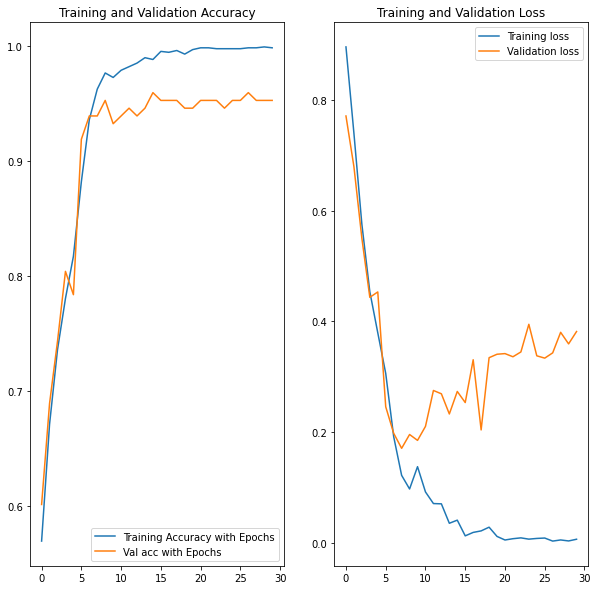

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS) , acc , label = 'Training Accuracy with Epochs')
plt.plot(range(EPOCHS) , val_acc , label = 'Val acc with Epochs')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS) , loss , label = 'Training loss')
plt.plot(range(EPOCHS) , val_loss , label = 'Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

 The first image is malignant
 The predicted label for the img is malignant


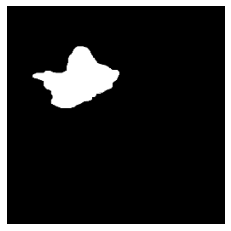

In [ ]:
for image_batch, label_batch in df_test.take(1) :
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = CLASS_NAMES[(label_batch[0].numpy())]
  first_img_predicted_label = CLASS_NAMES[np.argmax(model1.predict(image_batch)[0])]

  plt.imshow(first_image)
  plt.axis('off')
  print(f" The first image is {first_label}")
  print(f" The predicted label for the img is {first_img_predicted_label}")

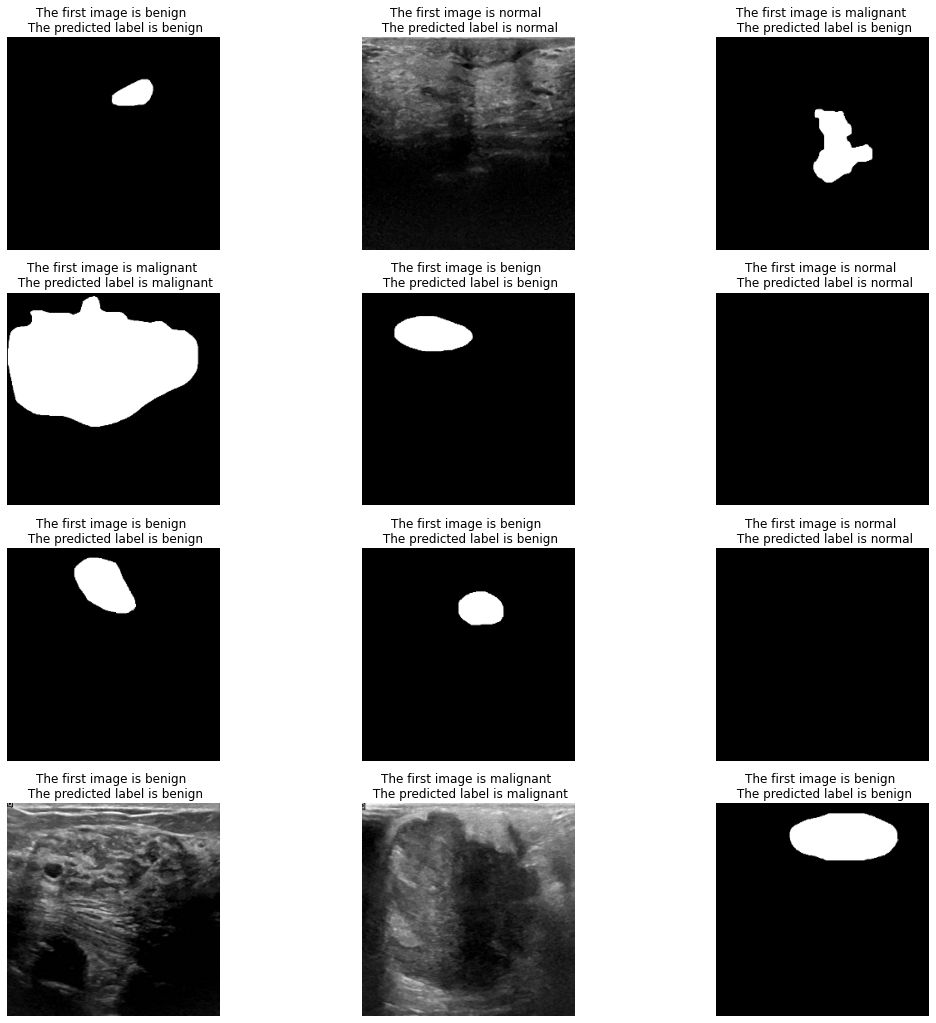

In [ ]:
plt.figure(figsize = (18,18))
for image_batch , label_batch in df_test.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i+1)
    img = image_batch[i].numpy().astype('uint8')
    label = CLASS_NAMES[label_batch[i].numpy()]
    predicted_label_batch = model1.predict(image_batch)
    predicted_label_for_single_img = CLASS_NAMES[np.argmax(predicted_label_batch[i])]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"The first image is {label} \n The predicted label is {predicted_label_for_single_img}")